<a href="https://colab.research.google.com/github/ernestomancebo/DeepLearningInPractice/blob/main/text_and_sequences/raw2word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Raw2Word Embedding

This notebooks attemps to gather raw text content and build a Word Embedding vector dictionary and feed it into a Neural Network for classification (a `Dense` layered network).

The first step to acomplish is to download the raw data from IMDB.

In [13]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm aclImdb_v1.tar.gz

In [15]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

Now we populate the dataset/corpus.

In [24]:
texts = []
labels = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    # Only text file are processed
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

In the next block we tokenize the IMDB corpus/data, after that we prepare the train and test sets.

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Training and embedding contrains
maxlen = 100
training_samples = 200
validation_samples = 1000
max_words = 10000

# Embedding tools/objects
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Tokenizer output
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

# Data to be feeded into the NN
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

print(f'Shape of the input tensor: {data.shape}')
print(f'Shape of the label tensor: {labels.shape}')

# We ramble a bit
indices = np.arange(data.shape[0])
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of the input tensor: (25000, 100)
Shape of the label tensor: (25000,)


Now we download the GloVe corpus and pre process it.

In [35]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B
!rm glove.6B.zip

--2021-01-19 15:51:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-19 15:51:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-19 15:52:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

Now `glove.6B.100d.txt` file is loaded and indexed.

In [41]:
glove_dir = 'glove.6B'
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


The GloVe matrix is now being prepared.

In [43]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

##Sequential Model for Text Embedding


This model is intended to do a classification task.

In [46]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


We freeze now the embedding layer (the first) and assing weights to it ussing the **Glove.6B** matrix 

In [47]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Finally we start training the model

In [48]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 2s 103ms/step - loss: 0.1950 - acc: 0.9026 - val_loss: 9.7067e-05 - val_acc: 1.0000
Epoch 2/10
7/7 [==============================] - 0s 27ms/step - loss: 8.9812e-08 - acc: 1.0000 - val_loss: 9.7063e-05 - val_acc: 1.0000
Epoch 3/10
7/7 [==============================] - 0s 26ms/step - loss: 9.0361e-08 - acc: 1.0000 - val_loss: 9.7058e-05 - val_acc: 1.0000
Epoch 4/10
7/7 [==============================] - 0s 25ms/step - loss: 7.5919e-08 - acc: 1.0000 - val_loss: 9.7049e-05 - val_acc: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 32ms/step - loss: 1.4976e-07 - acc: 1.0000 - val_loss: 9.7038e-05 - val_acc: 1.0000
Epoch 6/10
7/7 [==============================] - 0s 30ms/step - loss: 2.1889e-07 - acc: 1.0000 - val_loss: 9.7023e-05 - val_acc: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 26ms/step - loss: 8.6637e-08 - acc: 1.0000 - val_loss: 9.6997e-05 - val_acc: 1.0000
Epoch 8/10
7/7 [============================

In [49]:
model.save_weights('pre_trained_glove_model.h5')

Below the history is plotted and notice that it matches the training, it's odd perhaps the sape is not the same and it got randomnized.

In [51]:
print(f'Train Shape: {x_train.shape}. Validation Shape: {x_val.shape}')

Train Shape: (200, 100). Validation Shape: (1000, 100)


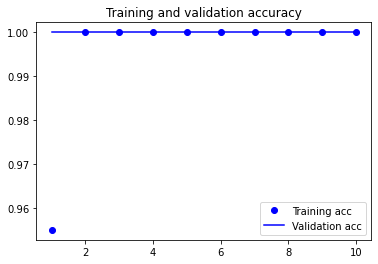

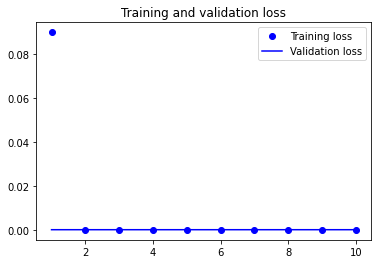

In [50]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Training again, but now without freezing the embedding layer.


Now we train a new model, but without freezing the embedding layer 

In [52]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 53ms/step - loss: 0.6145 - acc: 0.7403 - val_loss: 0.2138 - val_acc: 1.0000
Epoch 2/10
7/7 [==============================] - 0s 27ms/step - loss: 0.1234 - acc: 1.0000 - val_loss: 0.0443 - val_acc: 1.0000
Epoch 3/10
7/7 [==============================] - 0s 25ms/step - loss: 0.0244 - acc: 1.0000 - val_loss: 0.0169 - val_acc: 1.0000
Epoch 4/10
7/7 [==============================] - 0s 26ms/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.0083 - val_acc: 1.0000
Epoch 5/10
7/7 [==============================] - 0s 28ms/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 6/10
7/7 [==============================] - 0s 24ms/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 29ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 8/10
7/7 [==============================] - 0s 26ms/step - loss: 7.7836e-04 - acc: 1.0000 -

Let's see how it made it

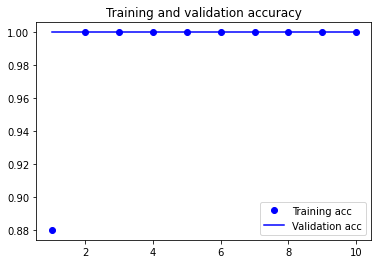

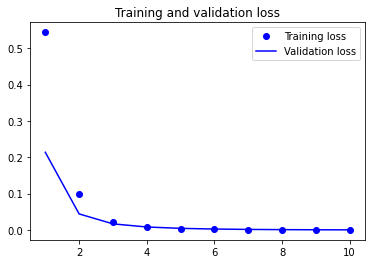

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

So far so good, now let's test over a test dataset

In [55]:
test_dir = os.path.join(imdb_dir, 'test')

texts = []
labels = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(test_dir, label_type)

  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()

      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)

# Now we prepare the test set
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

Evaluating over the test set, we get a `0.5` of accuracy, which means is a hard task perhaps the GloVe Embedding already employed.

In [56]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 11.9898 - acc: 0.5000


[11.989752769470215, 0.5]